In [1]:
# %pip install qubovert
# %pip install qiskit-aer
# %pip install qiskit
# %pip install pylatexenc
import json
import numpy as np
from datetime import datetime
from qubovert import QUBO, boolean_var
from qubovert.sim import anneal_qubo
from qubovert.utils import qubo_to_matrix
import random
import math
import pandas as pd

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

In [2]:
def filter_dates_before(input_dict, specified_date):
    """
    Filters the input dictionary to include only entries with dates before the specified date.

    Parameters:
    input_dict (dict): A dictionary with dates as keys in 'yyyy-mm-dd' format.
    specified_date (str): A date in 'yyyy-mm-dd' format to filter the dictionary.

    Returns:
    dict: A new dictionary containing only the entries with dates before the specified date.
    """
    if specified_date is None:
        return input_dict
    # Convert the specified date string to a datetime object
    specified_date_obj = datetime.strptime(specified_date, '%Y-%m-%d')
    
    # Create a new dictionary to hold the filtered results
    filtered_dict = {}
    
    # Iterate through the input dictionary
    for date_str, data in input_dict.items():
        # Convert the date string to a datetime object
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        
        # Check if the date is before the specified date
        if date_obj < specified_date_obj:
            filtered_dict[date_str] = data
            
    return filtered_dict

In [3]:
def read_input_file(input_file_name:str,
                    date_limit:str=None,
                    max_assets:int=None):
    '''Given a file, it returns the data related to it,
    ignoring data before `date_limit`
    '''
    with open(input_file_name, 'r') as file:
        data = json.load(file)
    
    ######################
    # DATA PREPROCESSING #
    ######################


    # Select only `max_assets` at random (for debuggin purposes)
    if max_assets:
        asset_names = list(data['assets'].keys())
        selected_asset_names = random.sample(asset_names, max_assets)
        
        for a in list(data['assets'].keys()):
            if a not in selected_asset_names:
                data['assets'].pop(a)


    # Filter out all assets with a number of history items different than the trend (i.e. 751)
    # We recognize that this approach works well only in cases where the number of outliers is reduced
    # as in this case (9 out of ~900 assets).

    filtered_data = {key:data[key] for key in ['evaluation_date']}
    filtered_data['assets'] = {}
    for a in data['assets']:
        if len(data['assets'][a]['history']) == 751:
            filtered_data['assets'][a] = data['assets'][a]

    data = filtered_data
    
    # Filter by date
    for a in data['assets']:
        # print(a)
        data['assets'][a]['history'] = filter_dates_before(data['assets'][a]['history'], date_limit)

    
    return  data


In [4]:
data = read_input_file("../eth_hackathon/input_one_day.json", max_assets=20, date_limit="2022-12-15")

In [5]:
def covariance_matrix(data):
    '''Returns the covariance matrix of the assets in `data`
    using history up to date `date_limit`'''

    assets = list(data['assets'].keys())
    # number of history elements (assumed to be equal for all assets)
    num_history_dates = len(data['assets'][assets[0]]['history'])
    # print(num_history_dates)
    # number of assets we are taking into account
    N_considered_assets = len(data['assets'])

    # Each row of assets_matrix represents a variable, and each column a single observation of all those variables.
    assets_matrix = np.empty((N_considered_assets, num_history_dates))

    for i, asset in enumerate(assets):
        history = data['assets'][asset]['history']
        ##TODO add filtering by date
        assets_matrix[i, :] = list(history.values())

    return np.corrcoef(assets_matrix)


In [6]:
cvm = covariance_matrix(data)


In [7]:

model = QUBO()
P = 1 
# bool_vars = np.zeros_like(cvm).tolist()

triui = np.triu_indices_from(cvm, k=1)
for k in range(len(triui[0])):
    i = triui[0][k]
    j = triui[1][k]
    # bool_vars[i][j] = boolean_var(f'x{i}_{j}')
    var = boolean_var(f'x_{i}_{j}')
    model += var * cvm[i][j]

portfolio_size = 10

# add slack variables to implement constraint
k = math.ceil(math.log2(portfolio_size))
s_variables = [boolean_var(f's_{i}_s') for i in range(k)]
tmp_model = QUBO()
for i in range(len(s_variables)):
    tmp_model+= s_variables[i] * (2 ** i)

model+= P*(tmp_model - portfolio_size)**2

solution = anneal_qubo(model, num_anneals=10).best



In [8]:
def get_selected_assets(data, sol):
    '''Given the solution of the optimization,
    it returns a dataset with name and history of the 
    selected assetes'''

    asset_names = list(data['assets'].keys())
    def parse_bool_var(x):
        name, i, j = x.split('_')
        if name == 'x':
            return int(i), int(j)
        return None, None 
    
    selected_assets_ids = ()
    for x in sol.state:
        if sol.state[x] == 1:
            i, j = parse_bool_var(x)
            if i is not None and j is not None:
                selected_assets_ids = (*selected_assets_ids, i, j)
    
    selected_assets = {asset_names[i]: data['assets'][asset_names[i]] for i in selected_assets_ids}

    with open('selected_assets.json', 'w') as fp:
        json.dump(selected_assets, fp)
    return selected_assets

get_selected_assets(data, solution)

{'CALM': {'environmentScore': None,
  'socialScore': None,
  'governanceScore': None,
  'peerEnvironmentPerformance': {'min': 4.99,
   'avg': 12.355000000000004,
   'max': 26.86},
  'peerGovernancePerformance': {'min': 1.65,
   'avg': 5.038596491228069,
   'max': 11.94},
  'peerSocialPerformance': {'min': 5.89,
   'avg': 10.894473684210528,
   'max': 20.62},
  'currency': 'USD',
  'marketCap': 4697623600.193024,
  'country': 'United States',
  'industry': 'Farm Products',
  'sector': 'Consumer Defensive',
  'fullTimeEmployees': 2929,
  'region': 'US',
  'ebitda': 1334518016,
  'totalDebt': 0,
  'overallRisk': 7,
  'history': {'2022-05-09': 41.25917053222656,
   '2022-05-10': 41.577430725097656,
   '2022-05-11': 41.86304473876953,
   '2022-05-12': 41.62638473510742,
   '2022-05-13': 41.34893035888672,
   '2022-05-16': 39.01504898071289,
   '2022-05-17': 39.431236267089844,
   '2022-05-18': 37.35032272338867,
   '2022-05-19': 37.67674255371094,
   '2022-05-20': 37.63593292236328,
   '202

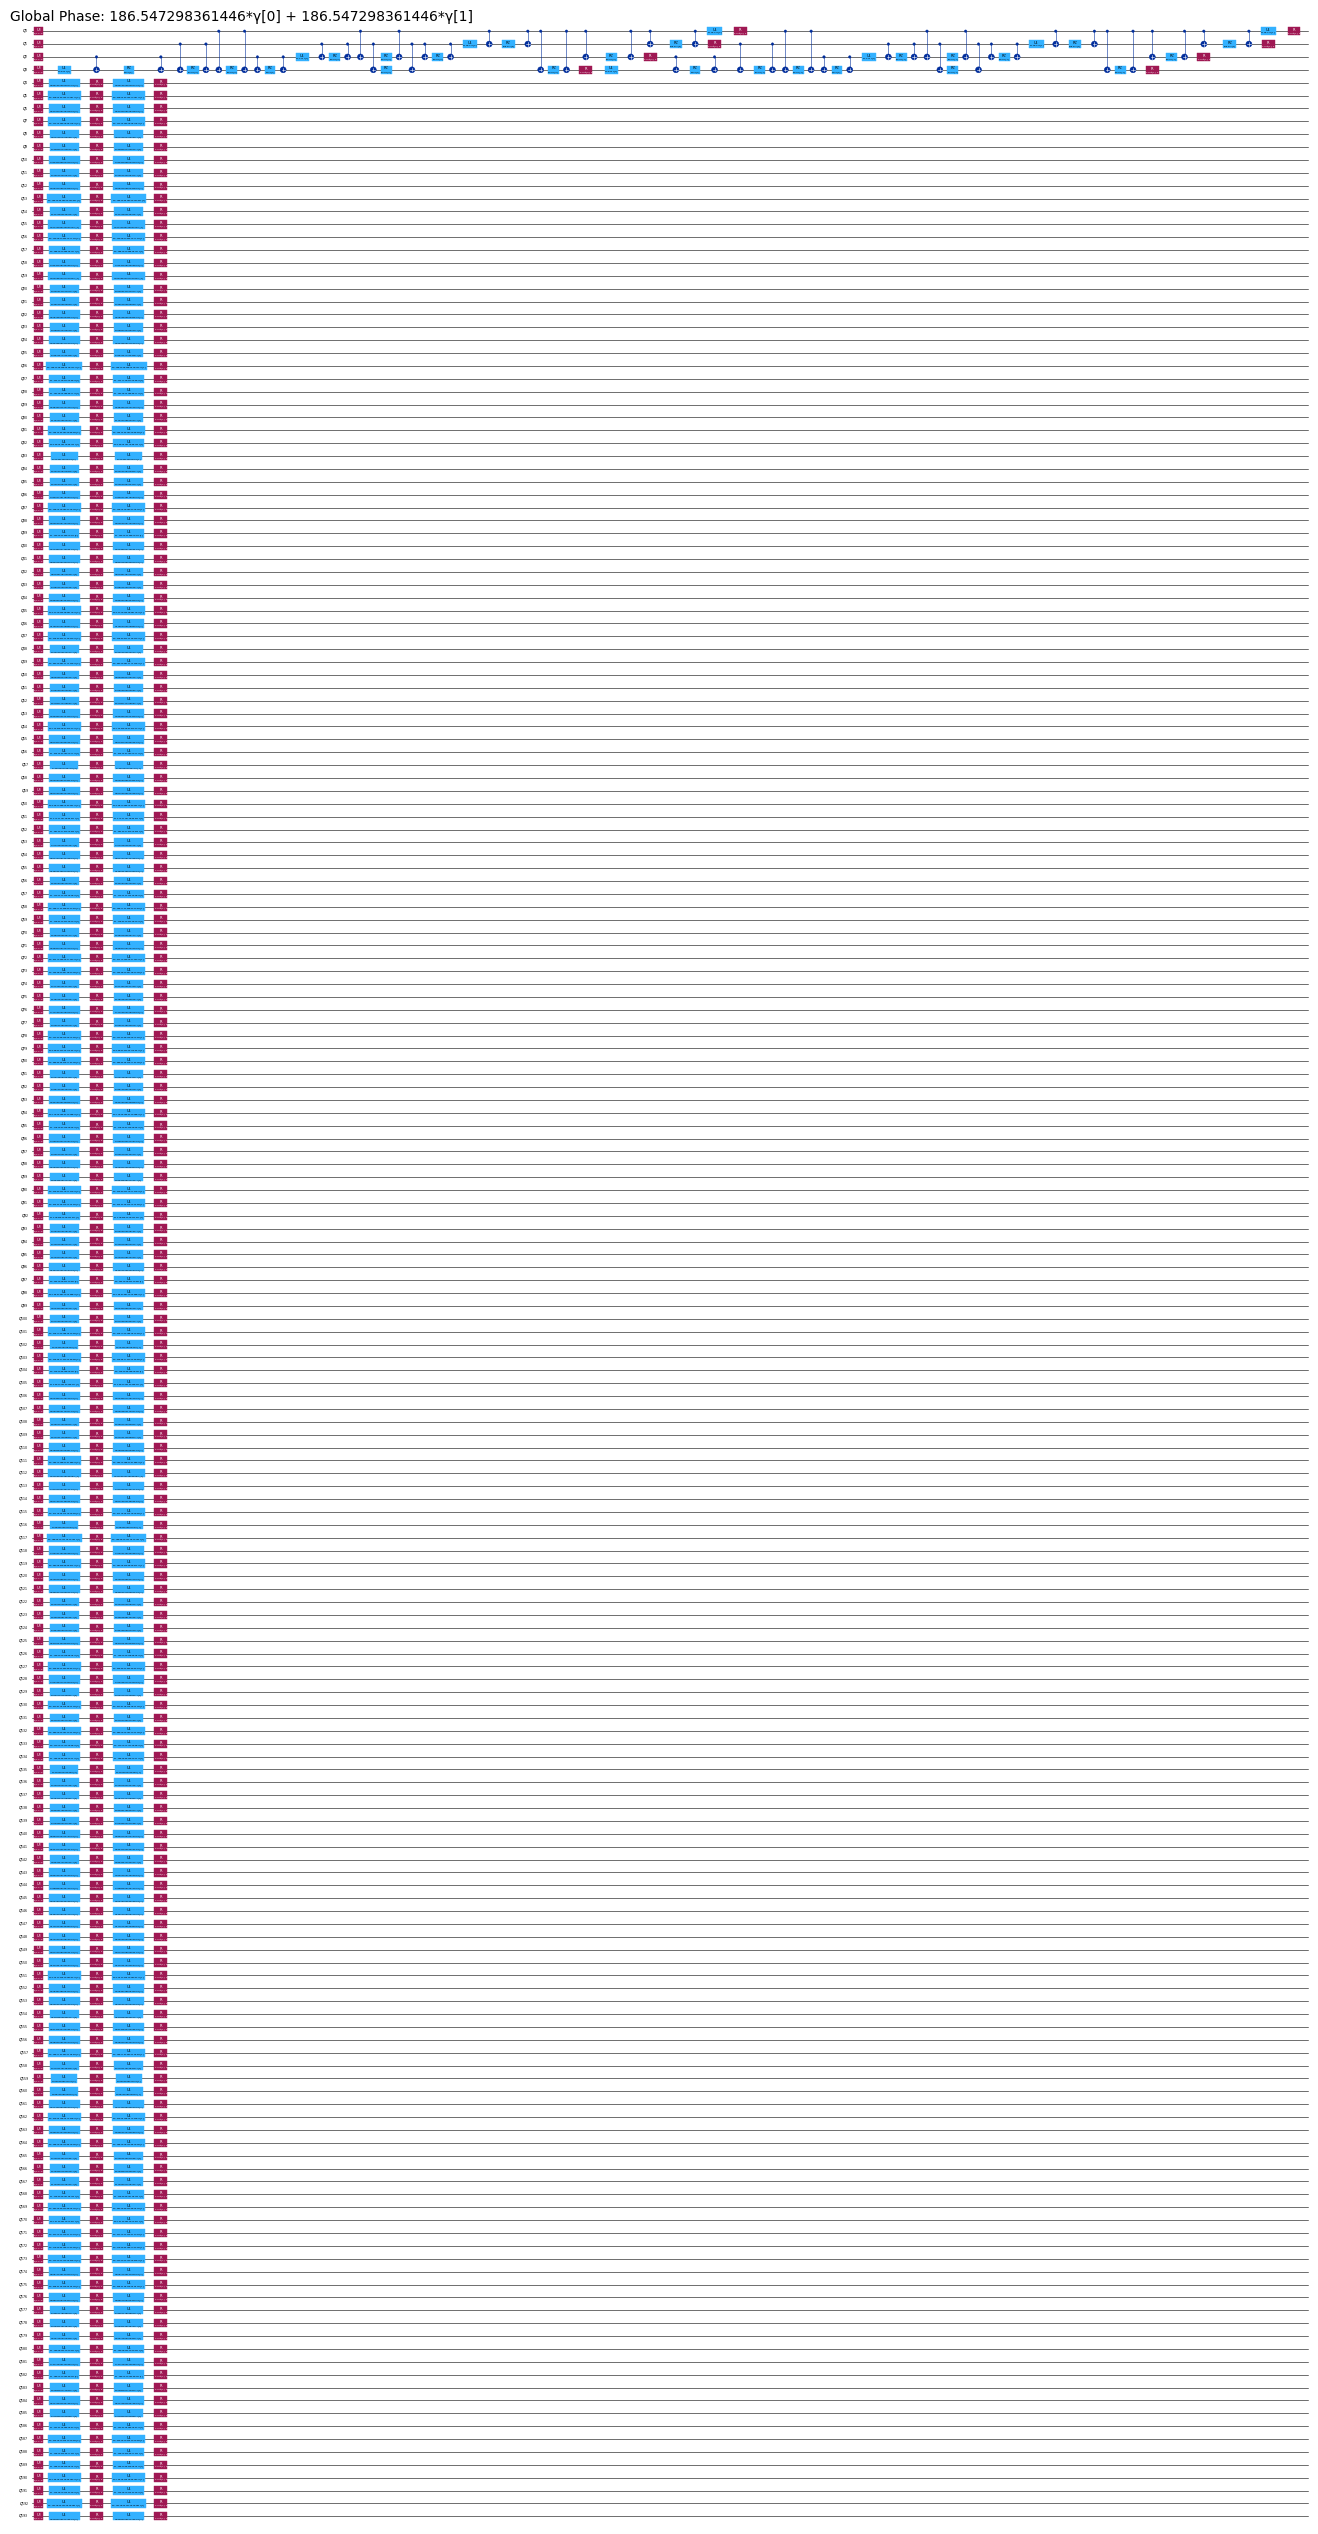

In [11]:
# np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})
def qubo_to_ising(model: QUBO):
    qubo = model.to_qubo()
    qubo_mat_dim = qubo.num_binary_variables
    # np_qubo = np.zeros((qubo_mat_dim,qubo_mat_dim))

    pauli_list = []
    # Z = ZGate().to_matrix()
    # HC = np.zeros_like(np_qubo)
    for i in range(qubo_mat_dim):
        for j in range(qubo_mat_dim):
            if (qubo[i,j] == 0):
                continue
            
            s = ['I' for i in range(qubo_mat_dim)]
            s[i] = s[j] = 'Z'

            pauli_list.append((''.join(s), qubo[i,j]))

    HC = SparsePauliOp.from_list(pauli_list)

    ansatz = QAOAAnsatz(HC, reps=2)
    return ansatz




qubo_to_ising(model).decompose(reps=3).draw('mpl', scale=0.2, fold=200)